# Figures for Paper
This notebook contains code that is used to generate some of the figures in the paper.

**NOTE:** Some path names need to be changed in order to run this correctly on your own device!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from DigitalPhantom import DigitalPhantom
import random

## Metabolite maps with and without Gradient

In [2]:
phantom_1 = DigitalPhantom(
    # General settings
    skeleton='BigBrainMR', 
    resolution=1.0, 
    path2phantom='./data/phantom/', 
    path2metabs='./data/metabolites/',
    from_scratch=False,
    # Metabolite settings
    concs_std=0.05,
    # Lipid settings
    sigma_lipid_spread=2.5, 
    # Gradient settings
    grad_metabs=[], 
    grad_settings=[0.5, 2, '+y']
    )

phantom_2 = DigitalPhantom(
    # General settings
    skeleton='BigBrainMR', 
    resolution=1.0, 
    path2phantom='./data/phantom/', 
    path2metabs='./data/metabolites/',
    from_scratch=False,
    # Metabolite settings
    concs_std=0.05,
    # Lipid settings
    sigma_lipid_spread=2.5, 
    # Gradient settings
    grad_metabs=['NAA'], 
    grad_settings=[0.5, 2, '+y']
    )

Initializing Digital Phantom...
Phantom found at "./data/phantom/BigBrainMR/1.0mm". Loading phantom...
Phantom loaded!
Initializing Digital Phantom...
Phantom found at "./data/phantom/BigBrainMR/1.0mm". Loading phantom...
Phantom loaded!


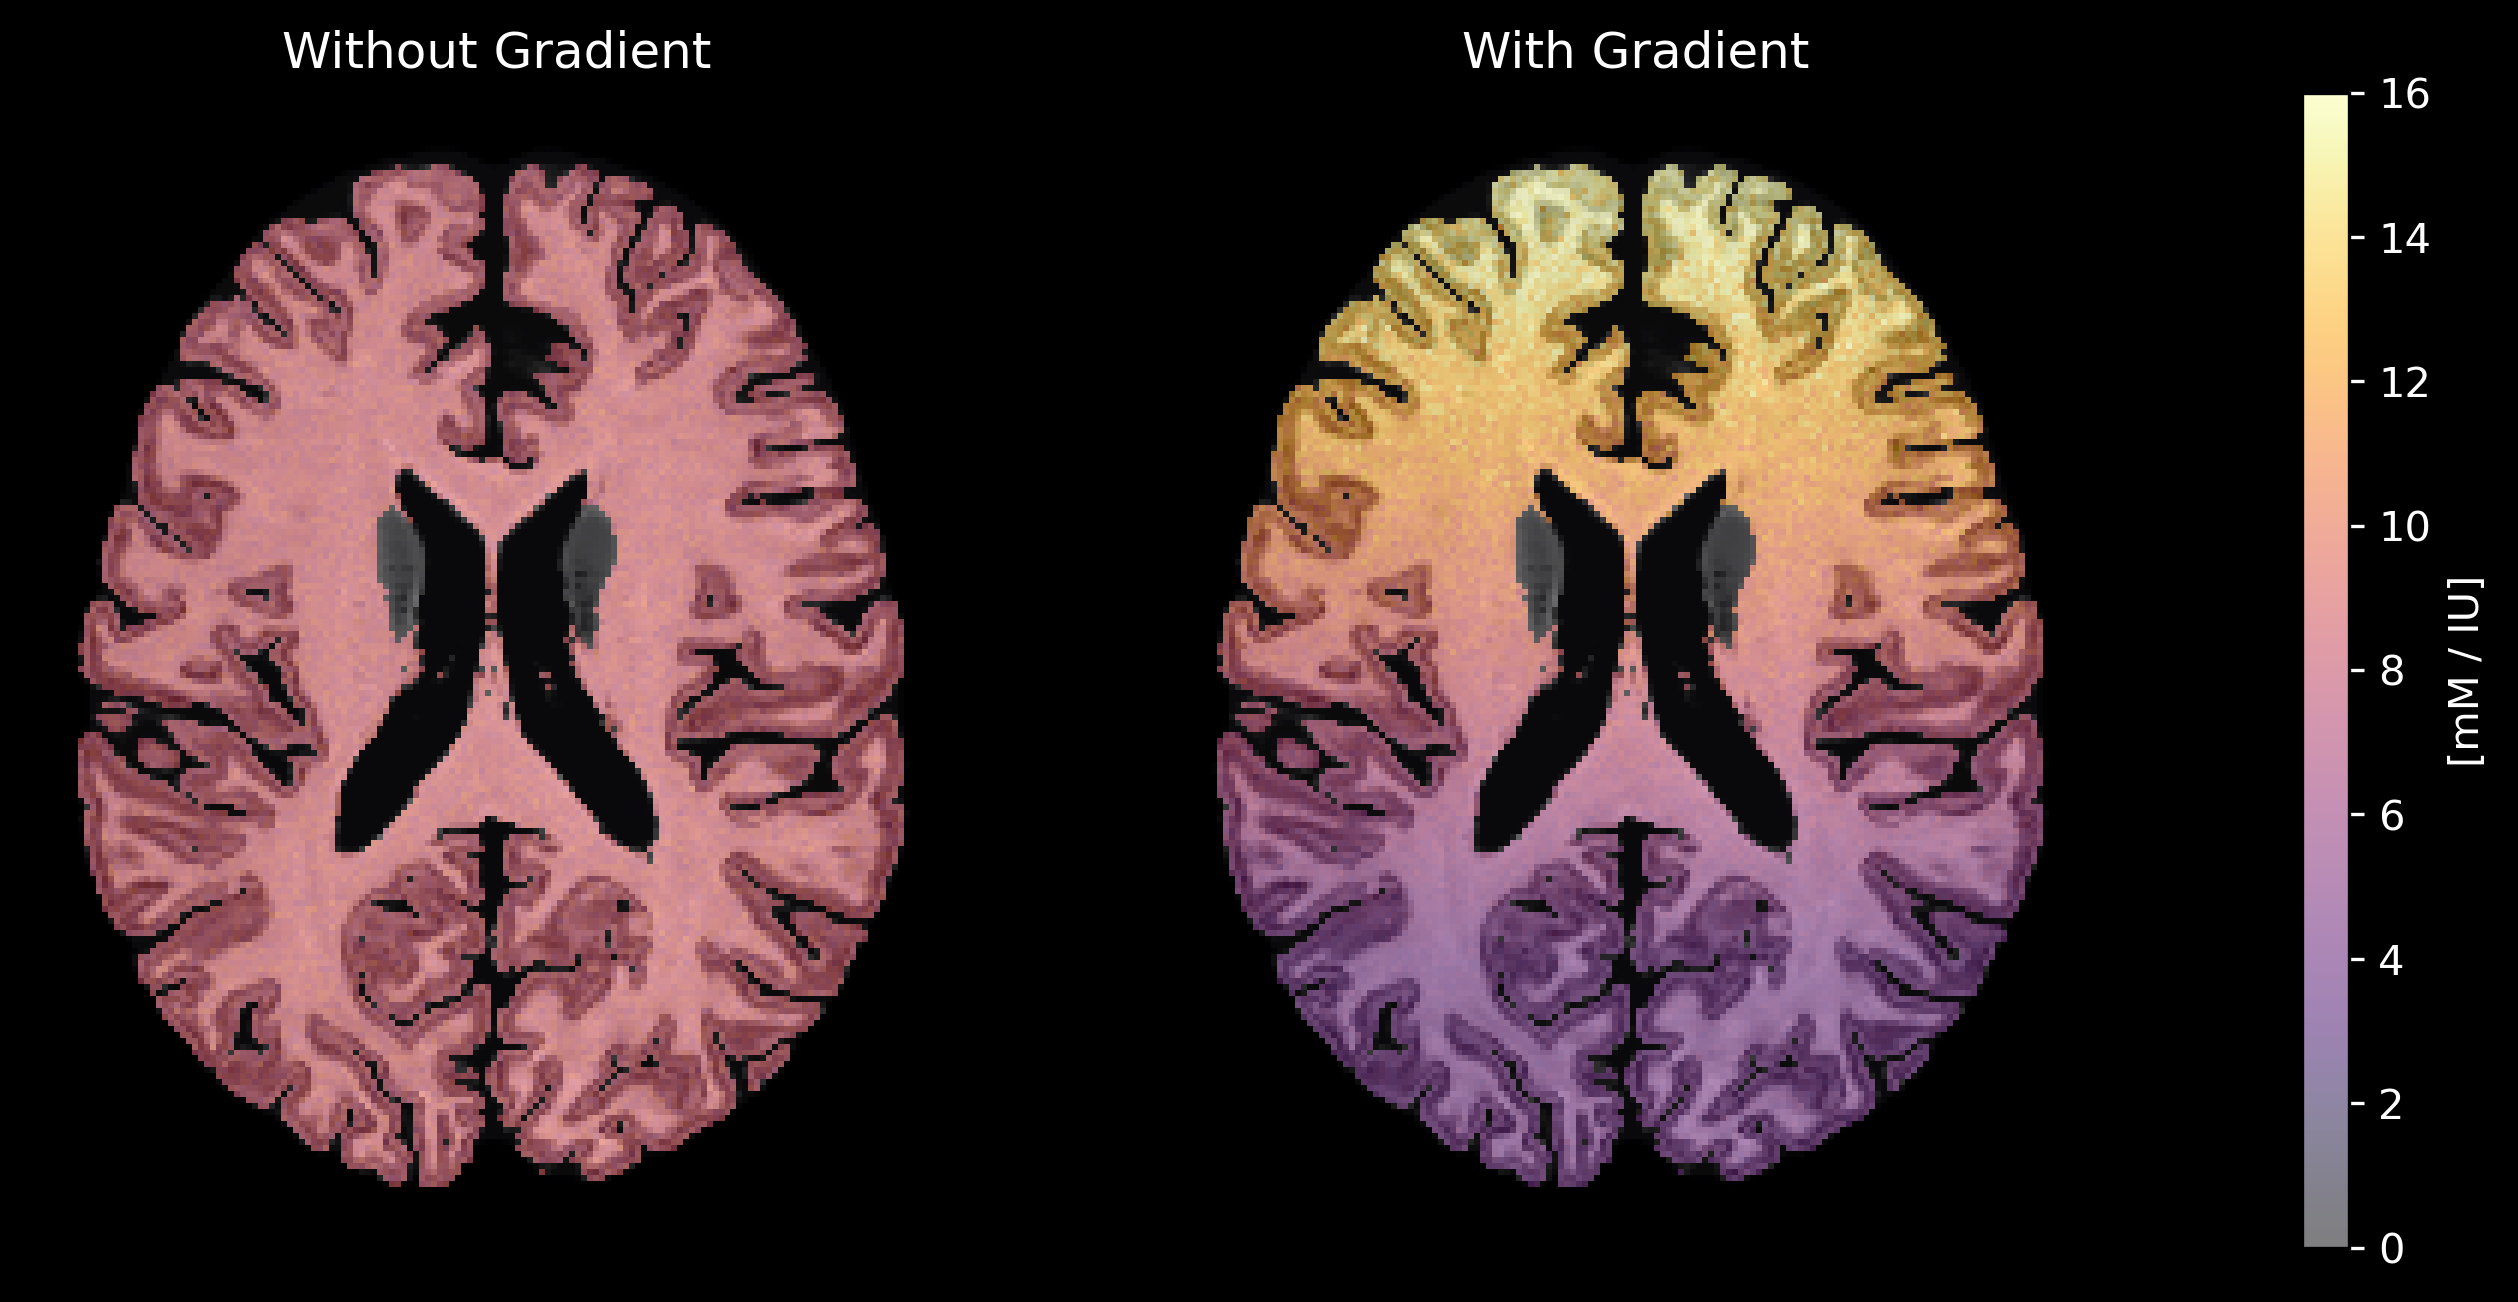

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# Function to plot metabolite maps side by side with a shared colorbar
def plot_metabolite_map_comparison(phantom_1, phantom_2, metab_name, cmap='inferno', vmin=None, vmax=None, slice_idxs=None):
    if phantom_1.skeleton == 'MNI':
        image_1 = phantom_1.subject['PD'].data[0]
    elif phantom_1.skeleton == 'BigBrainMR':
        image_1 = phantom_1.subject['T1wImage'].data[0]
    else:
        raise ValueError('Skeleton for phantom_1 not recognized.')

    if phantom_2.skeleton == 'MNI':
        image_2 = phantom_2.subject['PD'].data[0]
    elif phantom_2.skeleton == 'BigBrainMR':
        image_2 = phantom_2.subject['T1wImage'].data[0]
    else:
        raise ValueError('Skeleton for phantom_2 not recognized.')

    # Create metabolite maps
    metab_map_1 = phantom_1.create_metab_map(metab=metab_name)
    metab_map_2 = phantom_2.create_metab_map(metab=metab_name)

    if slice_idxs is None:
        slice_idxs = [metab_map_1.shape[0] // 2, metab_map_1.shape[1] // 2, metab_map_1.shape[2] // 2]

    # Define the layout using gridspec
    fig = plt.figure(figsize=(10, 5), dpi=300)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)  # Reserve space for colorbar on the right

    # Plot first image (without gradient)
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(np.rot90(image_1[:, :, slice_idxs[2]]), cmap='gray')
    im1 = ax1.imshow(np.rot90(metab_map_1[:, :, slice_idxs[2]]), cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
    ax1.axis('off')
    ax1.set_title('Without Gradient', color='white')

    # Plot second image (with gradient)
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(np.rot90(image_2[:, :, slice_idxs[2]]), cmap='gray')
    im2 = ax2.imshow(np.rot90(metab_map_2[:, :, slice_idxs[2]]), cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
    ax2.axis('off')
    ax2.set_title('With Gradient', color='white')

    # Add shared colorbar to the right of both images
    cbar_ax = fig.add_subplot(gs[2])
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
    cbar.set_label('[mM / IU]', color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(cbar.ax.get_yticklabels(), color='white')

    # Set background color to black
    fig.patch.set_facecolor('black')

    # plt.tight_layout()
    plt.show()

    return fig

# Call the function with both phantoms
fig = plot_metabolite_map_comparison(phantom_1, phantom_2, metab_name='NAA', cmap='inferno', vmin=0, vmax=16, slice_idxs=[0, 0, 95])


## Plot phantom images

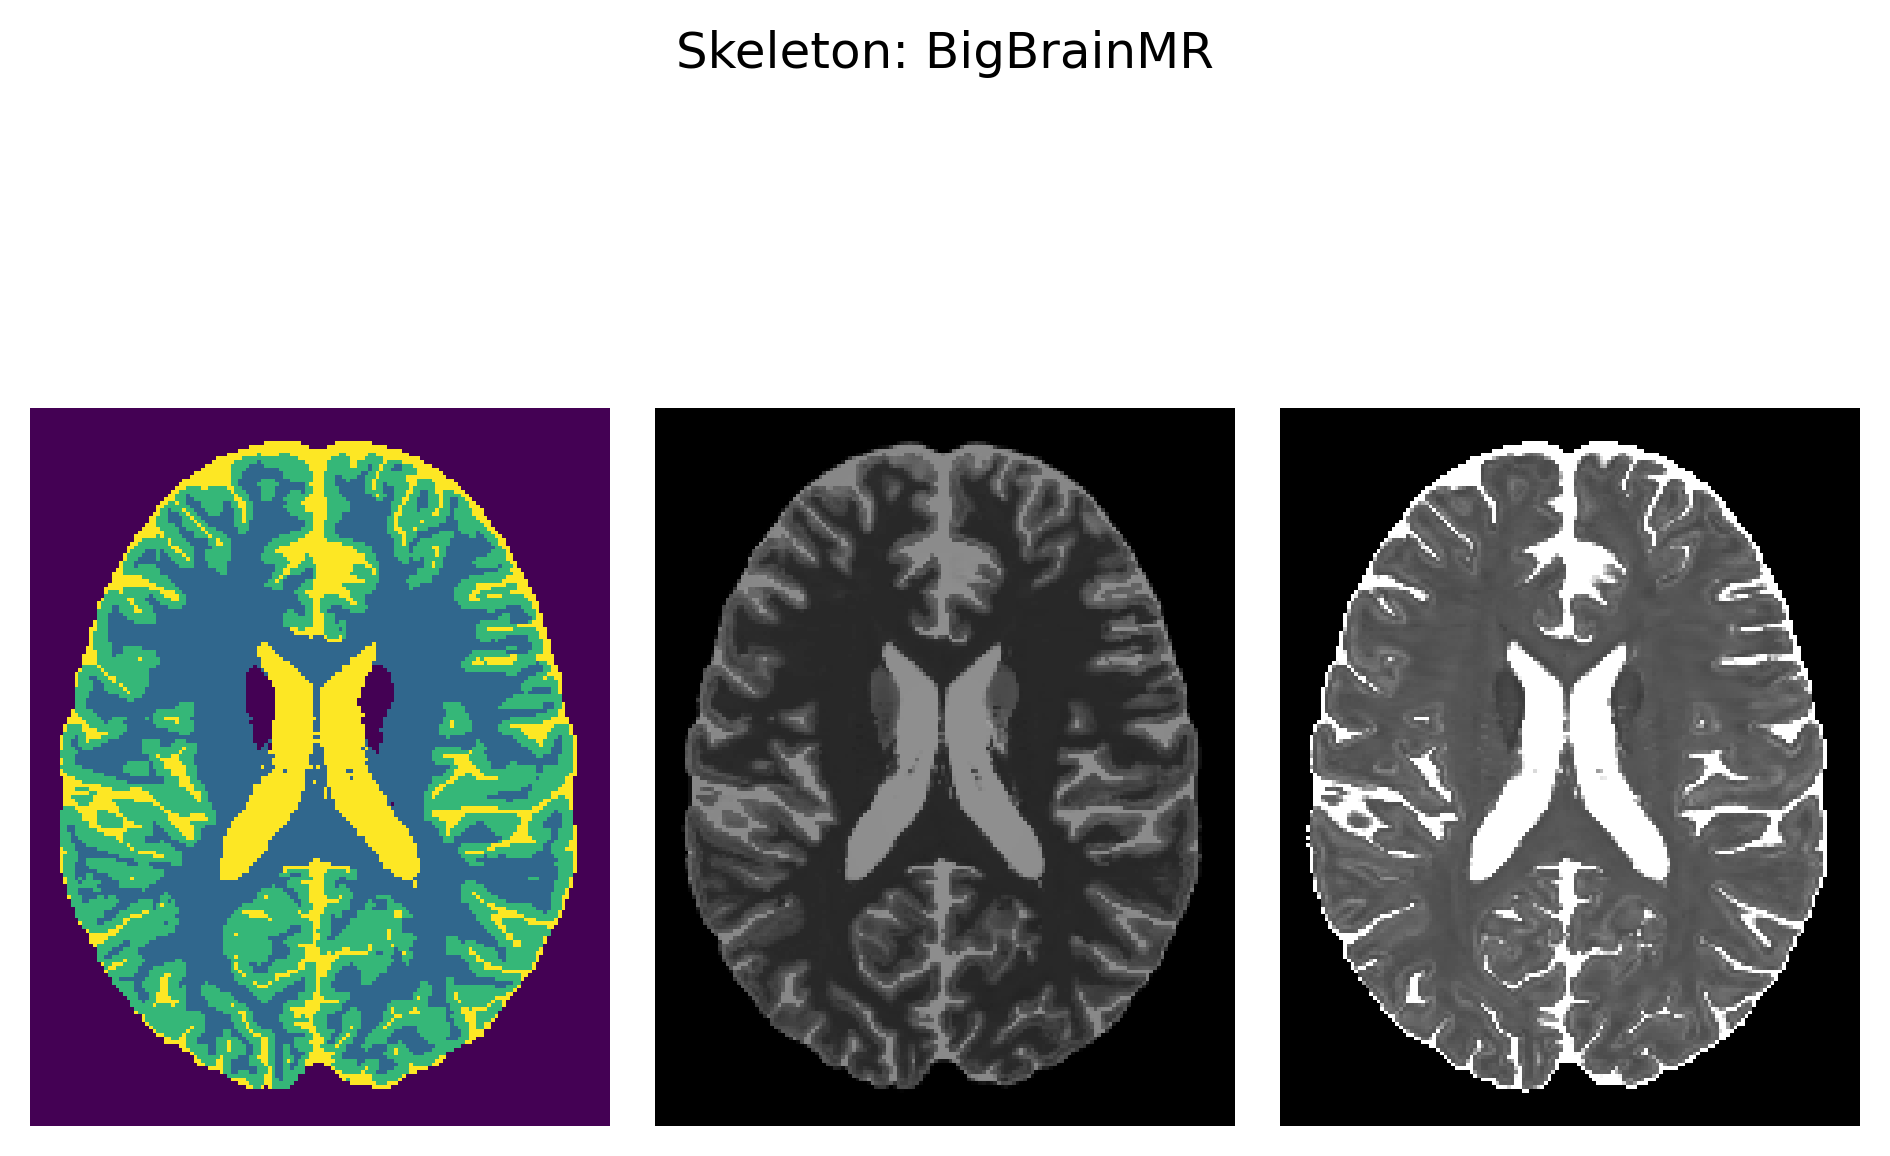

In [4]:
T1_map = phantom_1.T1
T2s_map = phantom_1.T2s
labels = phantom_1.labels

slice_idx = 95

fig, axs = plt.subplots(1, 3, dpi=300)

axs[0].imshow(np.rot90(labels[:, :, slice_idx]), cmap='viridis')
axs[0].axis('off')

axs[1].imshow(np.rot90(T1_map[:, :, slice_idx]), cmap='gray', vmin=0, vmax=5)
axs[1].axis('off')

axs[2].imshow(np.rot90(T2s_map[:, :, slice_idx]), cmap='gray', vmin=0, vmax=0.2)
axs[2].axis('off')

fig.suptitle(f'Skeleton: {phantom_1.skeleton}')
plt.tight_layout()
plt.show()





## Lipid map creation

In [5]:
phantom = DigitalPhantom(
    # General settings
    skeleton='MRiLab', 
    resolution=1.0, 
    path2phantom='./data/phantom/', 
    path2metabs='./data/metabolites/',
    from_scratch=False,
    # Metabolite settings
    concs_std=0.05,
    # Lipid settings
    sigma_lipid_spread=2.5, 
    # Gradient settings
    grad_metabs=[], 
    grad_settings=[0.5, 2, '+y']
    )

Initializing Digital Phantom...
Phantom found at "./data/phantom/MRiLab/1.0mm". Loading phantom...
Phantom loaded!


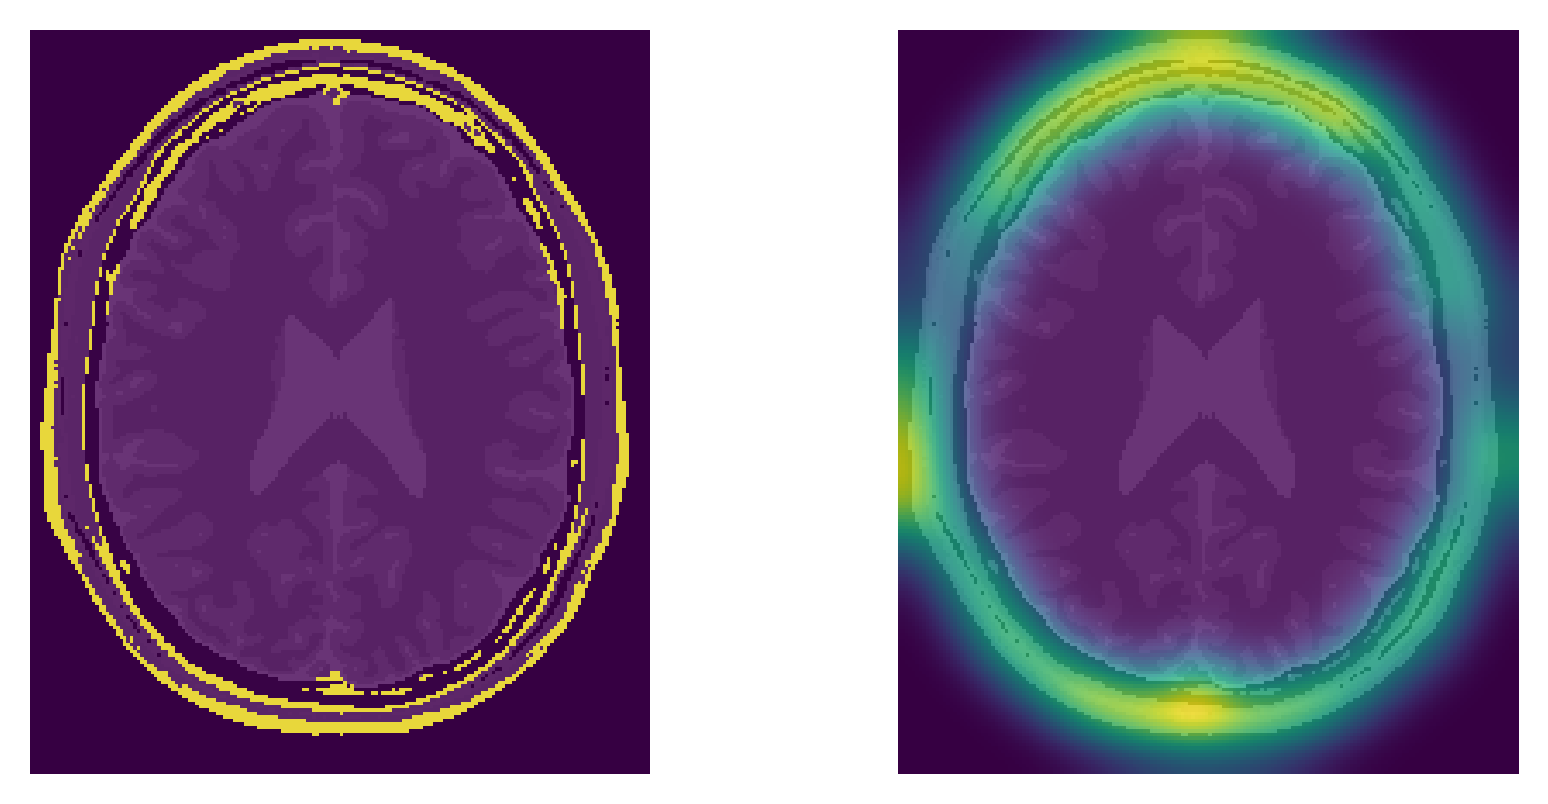

In [6]:
from scipy.ndimage import gaussian_filter
from loading.load_skeleton import load_mrilab_files


def generate_lipid_map(phantom, labels, lipid_region=4):
    """
    Generate a lipid map based on the distance transform of the lipid region.

    Args:
        labels (numpy.ndarray): A 3D numpy array representing the labels.
        lipid_region (int): The label of the lipid region.

    Returns:
        lipid_map (numpy.ndarray): A 3D numpy array representing the lipid map.
    """
    lipid_labels = (labels == lipid_region).astype(float)
    lipid_map = gaussian_filter(lipid_labels, sigma=8)
    lipid_map = lipid_map / np.max(lipid_map)

    return lipid_labels, lipid_map

subject_with_lipids = load_mrilab_files(path2skeleton=phantom.path2skeleton, resolution=phantom.resolution)
labels_with_lipids = np.array(subject_with_lipids['labels'].data[0])

lipid_labels, lipid_map= generate_lipid_map(phantom, labels_with_lipids, lipid_region=4)

slice_idx = 95
fig, axs = plt.subplots(1, 2, dpi=300)

axs[0].imshow(np.rot90(phantom.subject['PD'].data[0][:, :, slice_idx]), cmap='gray')
axs[0].imshow(np.rot90(lipid_labels[:, :, slice_idx]), cmap='viridis', alpha=0.8)
# axs[0].title.set_text('Lipid labels')
axs[0].axis('off')


axs[1].imshow(np.rot90(phantom.subject['PD'].data[0][:, :, slice_idx]), cmap='gray')
axs[1].imshow(np.rot90(lipid_map[:, :, slice_idx]), cmap='viridis', alpha=0.8)
# axs[4].title.set_text('Lipid map')
axs[1].axis('off')

# Add white space between subplots
plt.subplots_adjust(wspace=0.4) 

## Metabolite maps

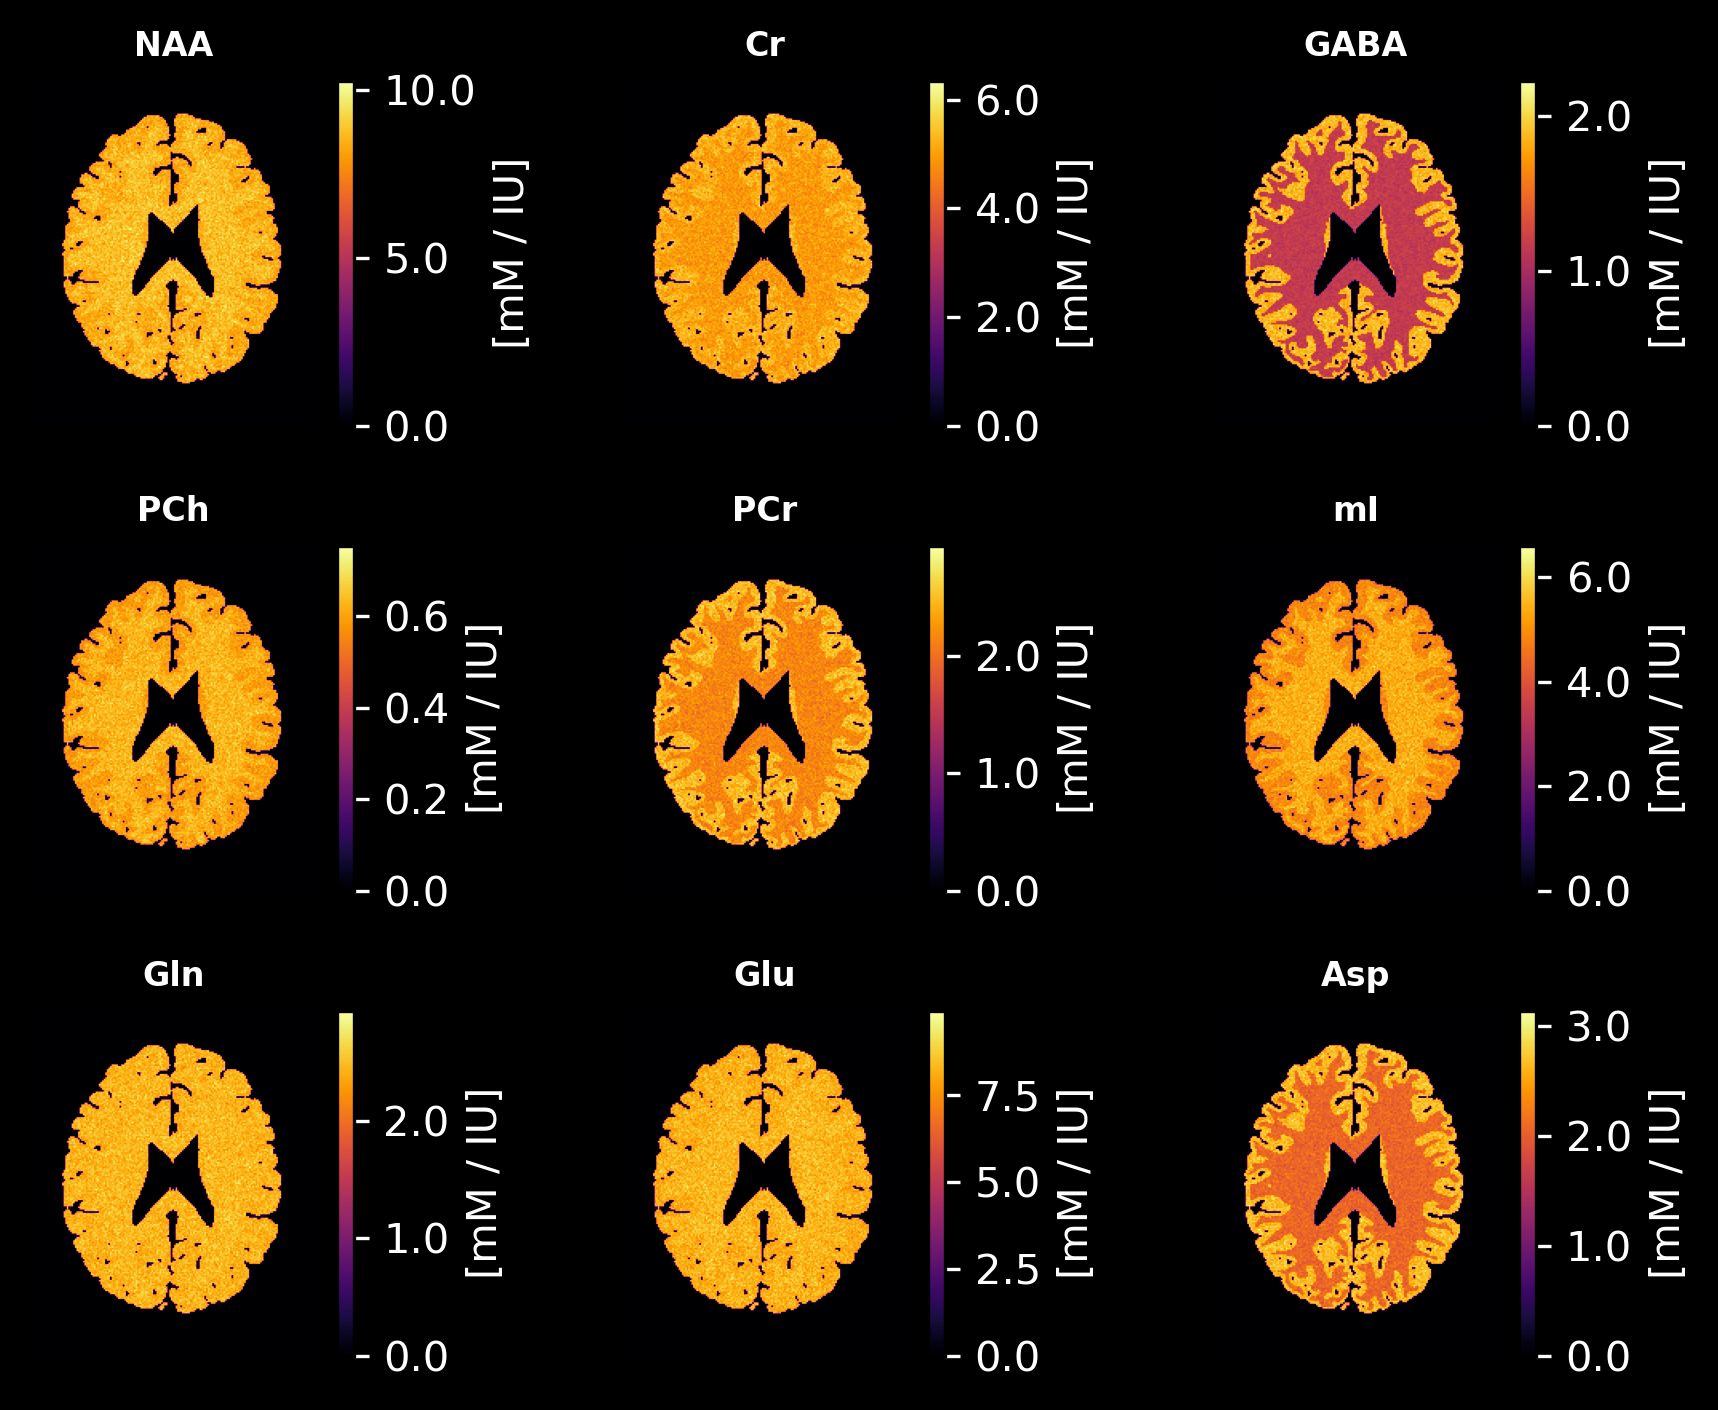

In [7]:
# Subset of metabolites with both GM and WM concentration information
metabs = ['NAA','Cr','GABA','PCh','PCr','mI','Gln','Glu','Asp']

maps = []
for metab in metabs:
    metab_map = phantom.create_metab_map(metab=metab)
    maps.append(metab_map)

fig, axs = plt.subplots(3, 3, dpi=300)
for i in range(3):
    for j in range(3):
        im = axs[i, j].imshow(np.rot90(maps[i*3+j][:, :, 95]), cmap='inferno')
        axs[i, j].axis('off')
        axs[i, j].title.set_text(metabs[i*3+j])
        axs[i, j].title.set_fontsize(8)
        axs[i, j].title.set_fontweight('bold')
        axs[i, j].title.set_color('white')

        # Add individual colorbars to the right of each subplot
        cbar = fig.colorbar(im, ax=axs[i, j], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelcolor='white')  # Set colorbar tick labels to white
        cbar.ax.yaxis.set_tick_params(color='white')  # Set colorbar tick color to white
        plt.setp(cbar.ax.get_yticklabels(), color='white')  # Set color of tick labels
        # Set colorbar ticks to 1 decimal place
        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        
        # Add unit label to each colorbar
        cbar.set_label('[mM / IU]', color='white')

# Set background color to black
fig.patch.set_facecolor('black')

# Ensure tight layout
plt.tight_layout()
plt.show()


## Water Residual

(7.5, 2.0)

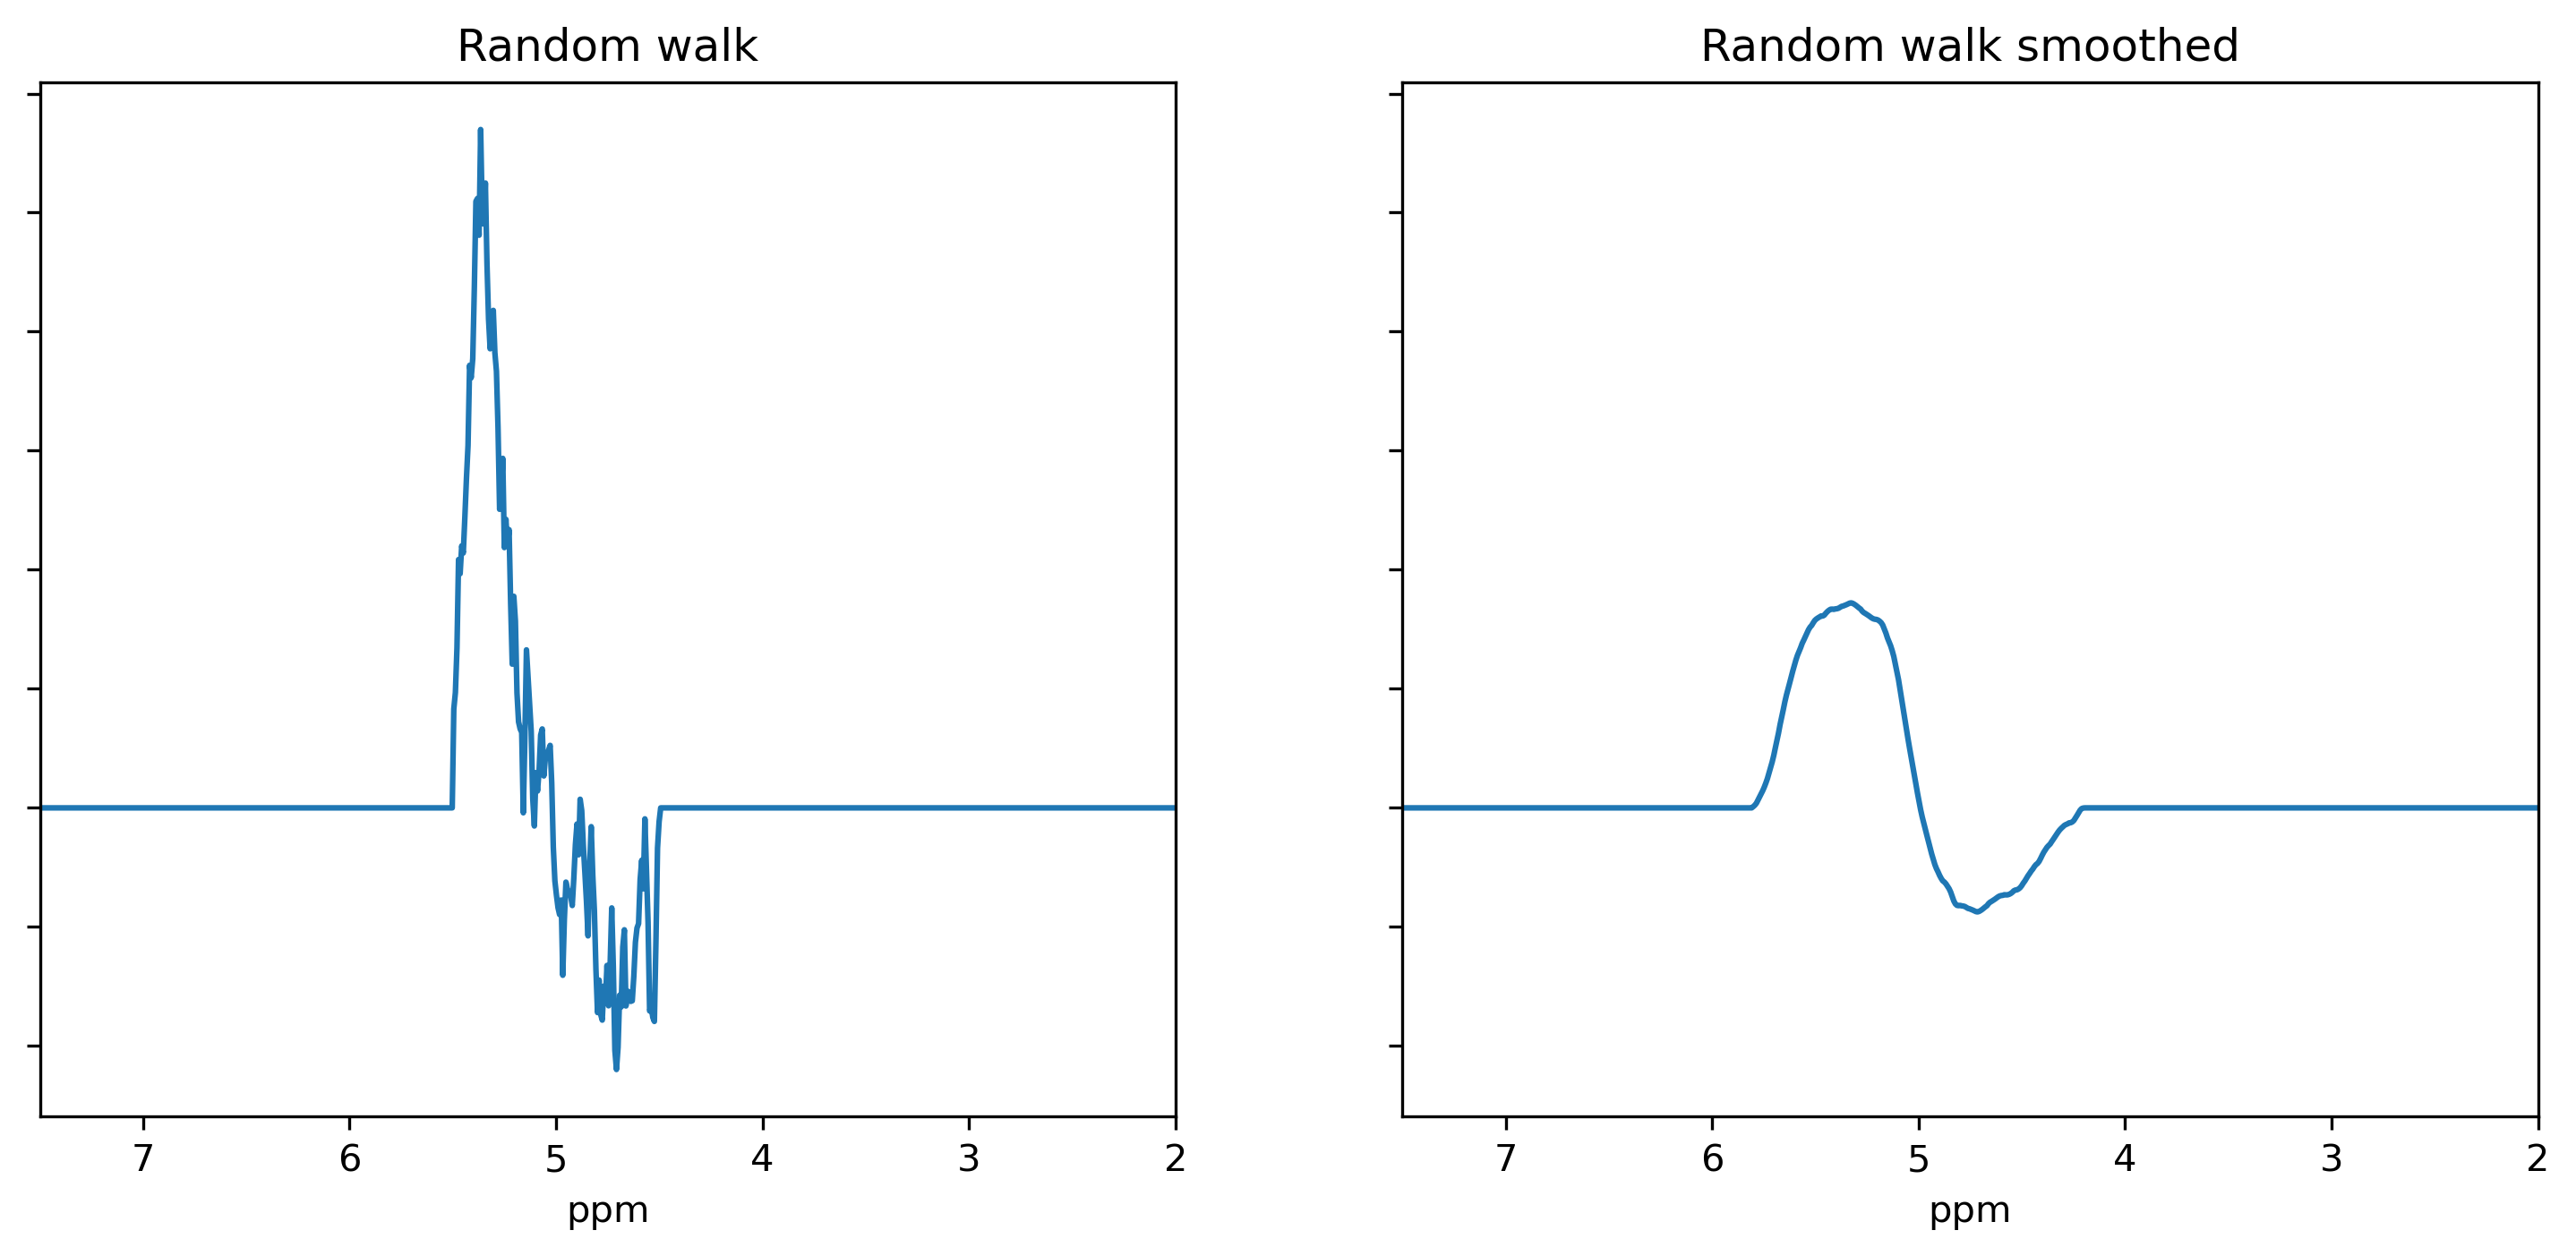

In [8]:
from scipy.signal import hilbert
from simulation.basis import Basis
from utils.definitions import residual_water_params as res_params

# Set seeds for reproducibility
import numpy as np
import random
random_seed = 96
np.random.seed(random_seed)
random.seed(random_seed)

def randomWalk(ppm_axis, rw_range=[4.5, 5.5], scale=1, smooth=10, ylim=[-1, 1]):
    """
        Produces a spectrum with a random walk within a specified ppm range.
        
        @param ppm_axis -- The ppm axis of the spectrum (an array of ppm values).
        @param rw_range -- The range in ppm where the random walk is applied.
        @param scale -- The y scale of the steps of the walk.
        @param smooth -- The smoothness of the walk.
        @param ylim -- The y limits, format [min, max].

        @returns -- The spectrum with the random walk applied only in the rw_range.
    """
    waveLength = len(ppm_axis)  # length of the ppm axis
    spectrum = np.zeros(waveLength)  # initialize spectrum with zeros

    # Find the indices corresponding to the rw_range within the ppm_axis
    start_idx = np.abs(ppm_axis - rw_range[0]).argmin()
    end_idx = np.abs(ppm_axis - rw_range[1]).argmin()

    # Initialize the random walk in the rw_range
    y = np.random.uniform(ylim[0], ylim[1])  # init randomly between limits
    wave = []
    for _ in range(end_idx - start_idx):
        step = np.random.normal(scale=scale)
        if ylim[0] <= y + step <= ylim[1]:
            y += step
        else:
            y -= step
        wave.append(y)
    
    # Insert the random walk into the spectrum at the correct indices
    spectrum[start_idx:end_idx] = wave

    # Smooth the spectrum
    spectrum_smooth = np.convolve(spectrum, np.ones(smooth) / smooth, mode='same')

    # Put in the complex domain
    spectrum_final = hilbert(spectrum_smooth)

    return spectrum, spectrum_smooth, spectrum_final

path2basis = './data/Basissets/3T/3T_PRESS_GE_35ms_noMM.BASIS'
phantom_metabs = list(phantom.metab_mapping.keys())

basis = Basis(path2basis, fmt=None, bw=2000, points=2048, metabs=[], phantom_metabs=phantom_metabs)

ppm_axis = basis.ppm

# Generate a random walk spectrum
spectrum_random, spectrum_smooth, spectrum_final = randomWalk(ppm_axis, rw_range=res_params['ppm_range'], scale=res_params['scale'], 
                                        #  smooth=res_params['smooth'],
                                         smooth=80, 
                                         ylim=res_params['ylim'])

# Plot the random walk spectrum
fig, ax = plt.subplots(1, 2, figsize=(12,5), dpi=300, sharex=True, sharey=True)

ax[0].plot(ppm_axis, spectrum_random)
ax[0].set_title('Random walk')
ax[0].set_xlabel('ppm')
ax[0].set_yticklabels([])

ax[1].plot(ppm_axis, spectrum_smooth)
ax[1].set_title('Random walk smoothed')
ax[1].set_xlabel('ppm')

ax[0].set_xlim([7.5, 2.0])


